In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from autoencode import Autoencoder
from multimodal_autoencode import MultimodalAutoencoder
from data_reader import DataReader, MultimodalDataset
from ipywidgets import interact, IntSlider

import keras.callbacks as kc

from sklearn.model_selection import GroupKFold, GroupShuffleSplit

from sklearn.preprocessing import StandardScaler

%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [17]:
print("Loading data...")

devset = pd.read_csv("../data/recsys/movieClipsRatingsTrain_AvgStd.csv", index_col=0)

movie_names = devset.index
groups = devset["movieId"]

audio_features = pd.read_csv("../data/recsys/Audio/i-vector/movieClips_ivec_feats_trte_sitem_gmms_512_tvDim_400_fullId.csv", index_col=0, header=None)
video_features = pd.read_csv("../data/recsys/Visual/AlexNetFc7Final/Avg/AlexNetFeatures - AVG - fc7.csv", index_col=0, header=None)

audio_features = audio_features.loc[movie_names]
video_features = video_features.loc[movie_names]

metadata_genre = pd.read_csv("../data/recsys/Metadata/GenreFeatures.csv", index_col=0)

metadata = metadata_genre.loc[devset.loc[movie_names]["movieId"]]
metadata_features = pd.DataFrame(index=movie_names, data = metadata.values, columns=metadata.columns)    

data_ = [metadata_features, audio_features, video_features]

Loading data...


In [48]:
data = MultimodalDataset(data_, groups)

In [49]:
latent_dim = 128    
config = {
    "encoder": [
        {
            "kwargs": {
                "activation": "relu",
                "units": 1024
            },
            "name": "hidden1",
            "type": "Dense"
        },
        {
            "name": "batchnorm1",
            "type": "BatchNormalization"
        },
        {
            "kwargs": {
                "rate": 0
            },
            "name": "dropout",
            "type": "Dropout"
        },
        {
            "kwargs": {
                "activation": "relu",
                "units": 128
            },
            "name": "latent",
            "regularizer": {
                "type": "l1",
                "value": 0
            },
            "type": "Dense"
        }
    ]
}

In [50]:
latent_shape = (latent_dim,)
input_shapes =  data.input_shapes

In [51]:
ae = MultimodalAutoencoder(config["encoder"],
                 None,
                 input_shapes=input_shapes,
                 latent_shape=latent_shape,
                 loss="mean_absolute_error",
                 optimizer_params=None)

In [52]:
print(input_shapes)
print(data.shapes)

[(18,), (400,), (4096,)]
[(5562, 18), (5562, 400), (5562, 4096)]


In [53]:
data_train, data_val = data.train_test_split()

In [26]:
data_train

[[Action         0
  Adventure      0
  Animation      0
  Children       0
  Comedy         1
  Crime          0
  Documentary    0
  Drama          1
  Fantasy        0
  Film_Noir      0
  Horror         0
  Musical        0
  Mystery        0
  Romance        1
  Sci_Fi         0
  Thriller       0
  War            0
  Western        0
  Name: 000000094_2Vam2a4r9vo, dtype: int64, 1     -0.003226
  2     -0.004777
  3     -0.008913
  4      0.003729
  5     -0.006402
  6      0.005183
  7     -0.002767
  8      0.001257
  9     -0.002517
  10     0.009262
  11    -0.001044
  12    -0.001476
  13    -0.000557
  14     0.001507
  15     0.002227
  16     0.001434
  17     0.002189
  18     0.000327
  19    -0.000300
  20    -0.004855
  21     0.003539
  22    -0.003681
  23    -0.006171
  24    -0.000985
  25     0.002074
  26    -0.005325
  27    -0.000663
  28     0.001607
  29     0.004847
  30     0.000913
           ...   
  371   -0.003104
  372    0.000351
  373    0.006714
  3

In [9]:
scores = ae.run_training(data, groups, random_state=100, epochs=1000, standardize=False, callbacks = [kc.EarlyStopping(monitor="val_loss", min_delta=0.000001, patience=10)])


Train on 4450 samples, validate on 1112 samples
Epoch 1/1000
4450/4450 [==============================] - 28s 6ms/step - loss: 2.3497 - output_loss: 0.6543 - val_loss: 2.7265 - val_output_loss: 0.5384
Epoch 2/1000
4450/4450 [==============================] - 26s 6ms/step - loss: 1.9664 - output_loss: 0.4630 - val_loss: 3.0088 - val_output_loss: 0.4751
Epoch 3/1000
4450/4450 [==============================] - 28s 6ms/step - loss: 1.8946 - output_loss: 0.4259 - val_loss: 3.4766 - val_output_loss: 0.4452
Epoch 4/1000
4450/4450 [==============================] - 27s 6ms/step - loss: 1.8375 - output_loss: 0.3966 - val_loss: 4.0458 - val_output_loss: 0.3939
Epoch 5/1000
4450/4450 [==============================] - 27s 6ms/step - loss: 1.8082 - output_loss: 0.3817 - val_loss: 4.1405 - val_output_loss: 0.4188
Epoch 6/1000
4450/4450 [==============================] - 28s 6ms/step - loss: 1.7768 - output_loss: 0.3695 - val_loss: 4.7288 - val_output_loss: 0.4168
Epoch 7/1000
4450/4450 [==========

In [26]:
print(scores)

[2.0409796119070562, 4.4907978949597425, 0.4961358094859622]


In [10]:
#ae.fit(data_train_scaled, epochs=600, validation_data=data_val_scaled, callbacks = [kc.EarlyStopping(monitor="val_loss", min_delta=0.000001, patience=10)])

In [11]:
predictions_val = ae.predict(data_val)

In [12]:
print(predictions_val)

[array([[ 0.05312079, -0.011284  ,  0.02212208, ...,  0.541146  ,
        -1.609213  , -5.5959454 ],
       [ 0.05312079, -0.011284  ,  0.02212208, ...,  0.541146  ,
        -1.609213  , -5.5959454 ],
       [ 0.05312079, -0.011284  ,  0.02212208, ...,  0.541146  ,
        -1.609213  , -5.5959454 ],
       ...,
       [ 2.0336342 ,  0.12389725,  0.01038771, ..., -1.0102196 ,
        -2.2339804 , -8.3243    ],
       [ 2.0336342 ,  0.12389725,  0.01038771, ..., -1.0102196 ,
        -2.2339804 , -8.3243    ],
       [ 2.0336342 ,  0.12389725,  0.01038771, ..., -1.0102196 ,
        -2.2339804 , -8.3243    ]], dtype=float32), array([[  0.45714033,   0.10846828,   0.02951655, ...,  -0.6737827 ,
         -3.174836  , -12.1584015 ],
       [  0.511197  ,   0.09537444,   0.02711119, ...,  -0.5763891 ,
         -3.1443605 , -12.115745  ],
       [  0.49247673,   0.0882456 ,   0.03242685, ...,  -0.67407835,
         -3.0013611 , -11.943249  ],
       ...,
       [  0.48422372,   0.1008514 ,   0.

In [13]:
data

[                       Action  Adventure  Animation  Children  Comedy  Crime  \
 moviename                                                                      
 000000094_2Vam2a4r9vo       0          0          0         0       1      0   
 000000094_4K8M2EVnoKc       0          0          0         0       1      0   
 000000094_DPQ47h-k-nw       0          0          0         0       1      0   
 000000094_E8LYvflSTAE       0          0          0         0       1      0   
 000000094_F4T2_xFNAqs       0          0          0         0       1      0   
 000000094_ITfoGnAkw4I       0          0          0         0       1      0   
 000000094_M-h1ERyxbQ0       0          0          0         0       1      0   
 000000094_RqCVbiHCYAA       0          0          0         0       1      0   
 000000094_Uyo69utc9bM       0          0          0         0       1      0   
 000000094_n1BXpNTsoB8       0          0          0         0       1      0   
 000000094_tMIO48oFmHc      

In [14]:
lengths = [d.shape[1] for d in data]
separators = np.cumsum([0] + lengths)
print(lengths)



[18, 400, 4096]


In [15]:
predictions_val = predictions_val[2]
data_val =  np.concatenate(data_val, axis=1)

In [16]:
print(predictions_val.shape)
print(data_val.shape)

(1112, 4514)
(1112, 4514)


In [17]:
print(data_val.shape)

(1112, 4514)


# Visualisation time

<IPython.core.display.Javascript object>


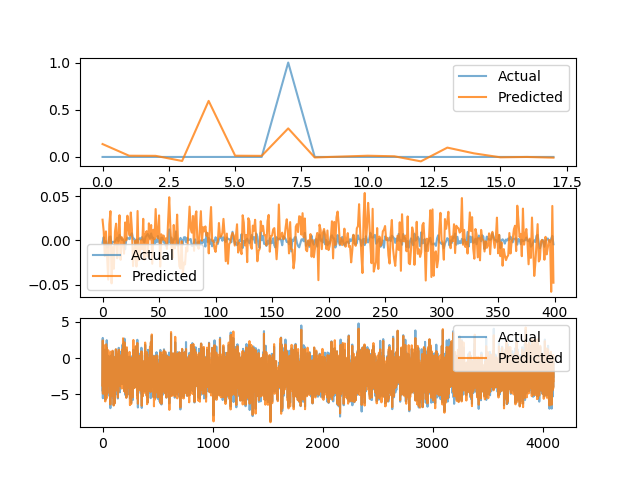

interactive(children=(IntSlider(value=0, description='idx', max=1111), Checkbox(value=False, description='resi…

In [25]:
fig = plt.figure()
subs = [fig.add_subplot(3,1,i+1) for i in range(3)]

def plot_prediction(true_values, predicted_values, subplot, residual):
    if residual:
        subplot.plot(true_values-predicted_values)
        subplot.legend(['Residuals'])
    else:
        subplot.plot(true_values, alpha=0.6)
        subplot.plot(predicted_values, alpha=0.8)
        subplot.legend(['Actual','Predicted'])

@interact(idx=IntSlider(min=0,max=data_val.shape[0]-1), residual=False, scaled=True)
def visualise(idx, residual=False, scaled=True):
    for i, sub in enumerate(subs):
        sub.clear()
        if not scaled:
            plot_prediction(scaler.inverse_transform(data_val)[idx, separators[i]:separators[i+1]],
                            scaler.inverse_transform(predictions_val)[idx, separators[i]:separators[i+1]],
                            sub, residual)
        else:
            #print(data_val[idx, separators[i]:separators[i+1]])
            #print(predictions_val)
            #print(predictions_val[idx, separators[i]:separators[i+1]])
            plot_prediction(data_val[idx, separators[i]:separators[i+1]],
                            predictions_val[idx, separators[i]:separators[i+1]],
                            sub, residual)

## Ideas

 * Fixed axes
 * Only one legend
 * Standardise
 * Plot size
 * Line plots or something else?

In [19]:
data_val.shape

(1112, 4514)

In [20]:
144+1456+1448

3048

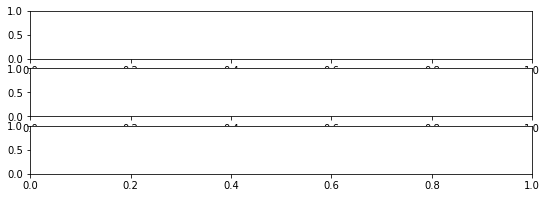

interactive(children=(IntSlider(value=0, description='idx', max=1112), Checkbox(value=False, description='resi…

In [21]:
fig = plt.figure(figsize=(9,3))
subs = [fig.add_subplot(3,1,i+1) for i in range(3)]

def plot_prediction2(true_values, predicted_values, subplot, residual):
    if residual:
        subplot.imshow(np.tile(true_values-predicted_values,(100,1)), 
                       interpolation='none')
        #subplot.plot(true_values-predicted_values)
        #subplot.legend(['Residuals'])
    else:
        n = len(predicted_values)
        viz = np.zeros([100,n])
        viz[:50] = predicted_values
        viz[50:] = true_values
        subplot.imshow(viz,interpolation='none',cmap='viridis')
        #subplot.plot(predicted_values, alpha=0.8)
        #subplot.plot(true_values, alpha=0.8)
        #subplot.legend(['Predicted', 'Actual'])

@interact(idx=IntSlider(min=0,max=data_val.shape[0]), residual=False)
def visualise2(idx, residual=False):
    for i, sub in enumerate(subs):
        sub.clear()
        plot_prediction2(data_val[idx, separators[i]:separators[i+1]],
                        predictions_val[idx, separators[i]:separators[i+1]],
                        sub, residual)

In [16]:
next(1)

TypeError: 'int' object is not an iterator